In [3]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [4]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255);
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray', vmin=0, vmax=255)
    ax[1].imshow(img2, cmap='gray', vmin=0, vmax=255)

outline = np.array([
    [-1, -1, -1],
    [-1,  10.5, -1],
    [-1, -1, -1]
])

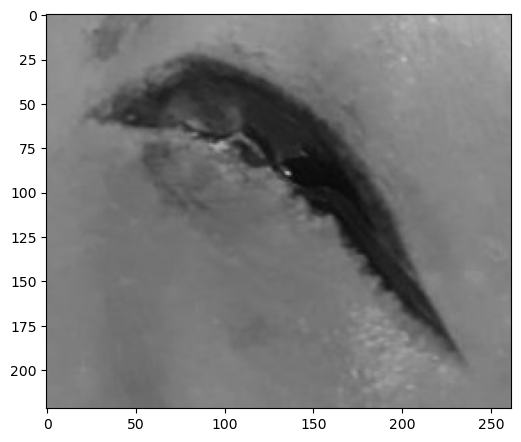

In [5]:
img = Image.open('cut_cropped.jpg')
img = ImageOps.grayscale(img)
#img = img.resize(size=(224, 224))
plot_image(img=img)

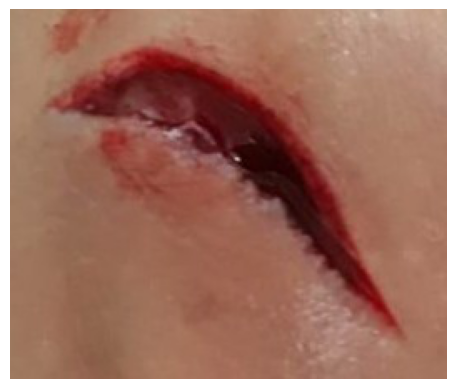

type(img)=<class 'numpy.ndarray'> img.shape=(222, 262, 3)


In [35]:
img = plt.imread('cut_cropped.jpg')
plt.imshow(img)                       
plt.axis('off')                       
plt.show()
print(f'{type(img)=}', f'{img.shape=}')

Text(0.5, 1.0, 'Blue Channel(in Grayscale)')

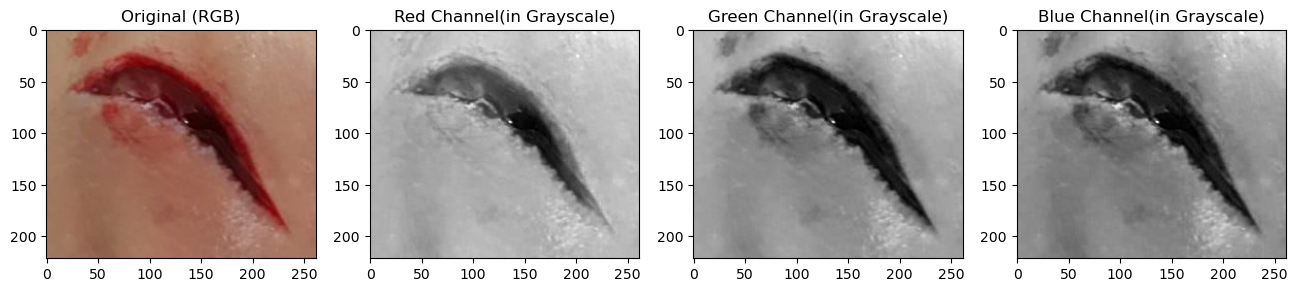

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

ax_original, ax_red, ax_green, ax_blue = ax

ax_original.imshow(img)
ax_original.set_title('Original (RGB)')

# ALL row & ALL columns of layer 0
ax_red.imshow(img[:, :, 0], cmap='gray')
ax_red.set_title('Red Channel(in Grayscale)')

# ALL row & ALL columns of layer 1
ax_green.imshow(img[:, :, 1], cmap='gray')
ax_green.set_title('Green Channel(in Grayscale)')

# ALL row & ALL columns of layer 2
ax_blue.imshow(img[:, :, 2], cmap='gray')
ax_blue.set_title('Blue Channel(in Grayscale)')

In [6]:
def black_and_white(img: np.array) -> np.array:
    min=np.min(img)
    max=np.max(img)
    x_len = img.shape[1] #columns
    y_len = img.shape[0] #rows
    # 2D array of zeros
    new_img = np.zeros(shape=(y_len, x_len))
    
    # Iterate over the rows
    for y in range(y_len):
        # Iterate over the columns
        for x in range(x_len):
            # img[y, x] = individual pixel value
            if img[y,x] <= (min+max)*0.5*(4.5/6):
                new_img[y,x] = 255
            else:
                new_img[y,x] = 0
            
    return new_img


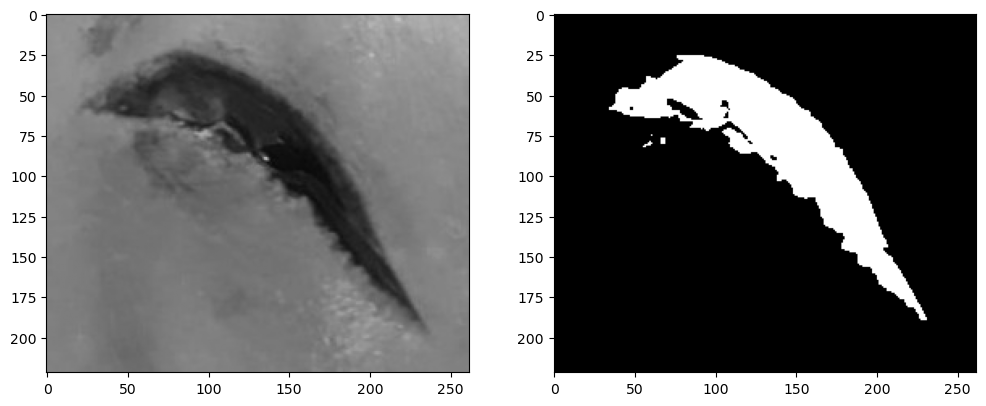

In [7]:
img_btw = black_and_white(np.array(img))
plot_two_images(
    img1=img, 
    img2=img_btw
)

In [8]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

def convolve(img: np.array, kernel: np.array) -> np.array:
    # Assuming a square image
    tgt_size = calculate_target_size(img.shape[0], kernel.shape[0])
    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img

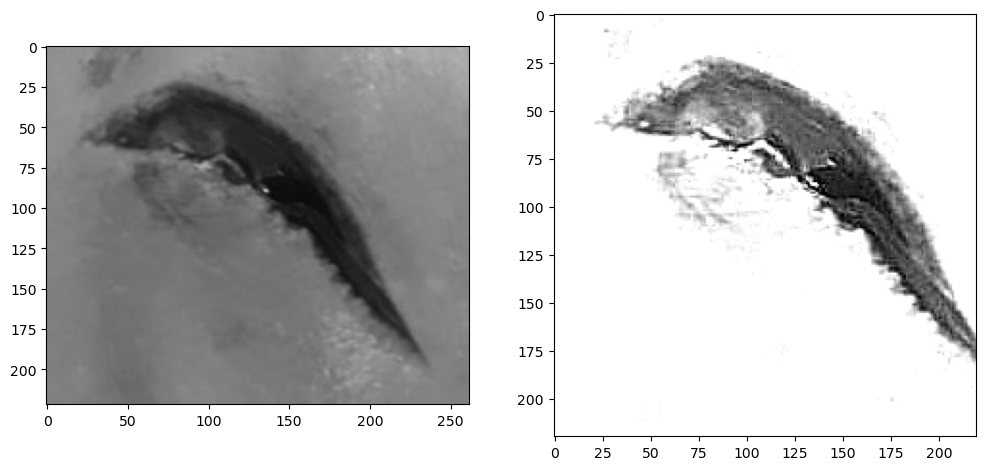

In [9]:
img_outlined = convolve(img=np.array(img), kernel=outline)
plot_two_images(
    img1=img, 
    img2=img_outlined
)

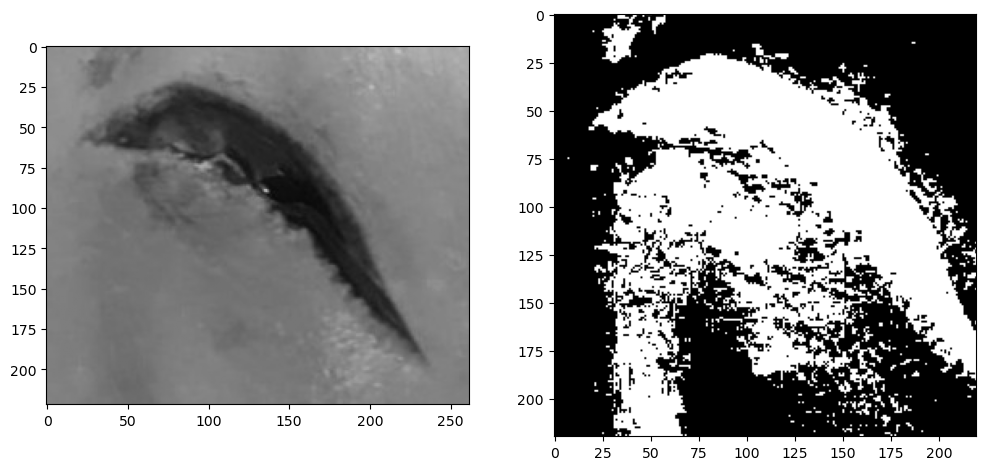

In [10]:
img_btw2 = black_and_white(img_outlined)
plot_two_images(
    img1=img, 
    img2=img_btw2
)

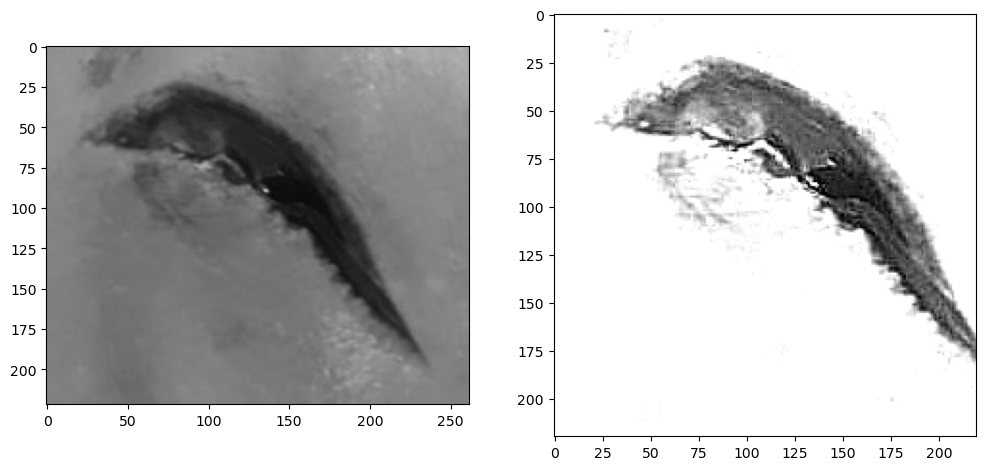

In [11]:
def negative_to_zero(img: np.array) -> np.array:
    img = img.copy()
    img[img < 0] = 0
    return img

plot_two_images(
    img1=img, 
    img2=negative_to_zero(img=img_outlined)
)

KeyboardInterrupt: 

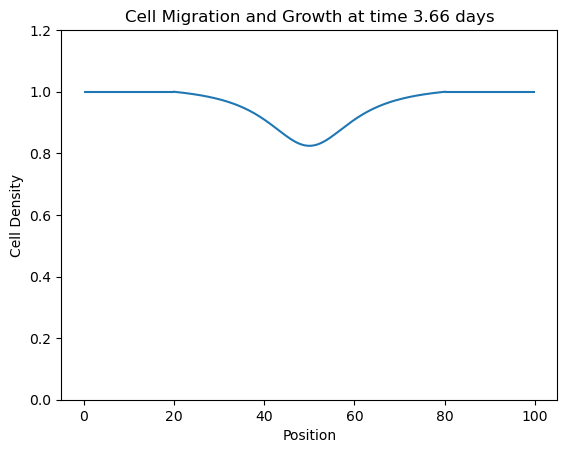

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Remove limitation on the size of animation!
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Parameters for the Model
L = 100 # Length of Surface
nx = 200 # Number of Points for Length
dx = 60 / (nx -1) # Length Step Size
D_0 = 1.0 # Diffusion Coefficient
A = 1 # Contact Inhibition Constant
alpha = 1 # Growth Rate per Day, Exp value of Alpha = 1.8*10**(-3)
dt = 0.01 # Time Step Size (Days) --> Cannot be too big or equation will blow up
nt = 2000 # Numer of Points for Time
days = dt * nt # Total Number of Days

# Distance and Time Points
x = np.linspace(20, 80, nx) # Restrict to your boundaries
t = np.linspace(0, days, nt)

# Setting up the Cell Density Array --> Add your own shape of the wound
# Ensure u = 1 at two ends, in this case value 20 and 80
u = 0.001 * (x - 50) ** 2 + 0.1

# Tried Setting the Boundaries to Be Part of Data --> Wound starts Widening
# left_boundary = x[x < 20]
# left_boundary[:] = 1
# wound = x[(x >= 20) & (x <= 80)]
# wound = 0.001 * (wound - 50) ** 2 + 0.1
# right_boundary = x[x > 80]
# right_boundary[:] = 1
# u = np.concatenate((left_boundary, wound, right_boundary))

fig, ax = plt.subplots()
line, = ax.plot(x, u) # Get line specifically
ax.hlines(1, 0, 20) # Left Boundary
ax.hlines(1, 80, 100) # Right Boundary
ax.set_ylim(0, 1.2)
ax.set_xlabel("Position")
ax.set_ylabel("Cell Density")

def model(u):
    # Setting up Array
    du_dx = np.zeros_like(u)
    # First Order Difference (Forward), for first index
    du_dx[0] = (u[1] - u[0]) / dx
    # First Order Difference (Central)
    du_dx[1:-1] = (u[2:] - u[0:-2]) / (2 * dx)
    # First Order Difference (Backwards), for last index
    du_dx[-1] = (u[-1] - u[-2]) / dx

    # Setting up Array
    d2u_dx2 = np.zeros_like(u)
    # Second Order Difference (Forward), for first index
    d2u_dx2[0] = (u[2] - 2 * u[1] + u[0]) / dx**2
    # Second Order Difference (Central)
    d2u_dx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[0:-2]) / dx**2
    # Second Order Difference (Backwards), for last index
    d2u_dx2[-1] = (u[-1] - 2 * u[-2] + u[-3]) / dx**2

    return du_dx, d2u_dx2

def update(frame):
    # Access global value for u
    global u
    time = frame * dt
    # Obtain du_dx and d2u_dx2 values for each frame
    du_dx, d2u_dx2 = model(u)
    first_term = D_0 * (du_dx ** 2) * (-A) * ((A + u) ** (-2))
    second_term = D_0 * A * ((A + u) ** (-1)) * d2u_dx2
    third_term = alpha * u * (1 - u)
    du_dt = first_term + second_term + third_term
    # Full Equation:
    # du_dt = D_0 * (du_dx ** 2) * (-A * ((A + u) ** (-2))) + (A / (A + u)) * D_0 * d2u_dx2 + alpha * u * (1 - u)
    # Keep updating the title with each new frame
    ax.set_title(f"Cell Migration and Growth at time {time:.2f} days")
    # Updating Cell Density values only --> Plot first before updating for next frame
    line.set_ydata(u)
    # Explicit Euler Method
    u += (du_dt * dt)
    return line, # Return line specifically

# fig is the figure needed to be animated, update should be a func that is called for each frame, takes in an iterable frames as an argument
# frames is the iterable that will be passed through update, interval is delay between frames
ani = FuncAnimation(fig, update, frames = nt, interval = 30, blit = True)

# .to_jshtml() generates a HTML representation of the animation
# HTML() render argument as HTML
display(HTML(ani.to_jshtml()))

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = 1.0      # Contact inhibition constant
X = 1.0      # Total simulation length (x-axis)
Y = 1.0      # Total simulation length (y-axis)
T = 0.5      # Total simulation duration
nx = 51      # Number of spatial points (x-axis)
ny = 51      # Number of spatial points (y-axis)
nt = 1000    # Number of time steps

dx = X / (nx - 1)
dy = Y / (ny - 1)
dt = T / nt

# Spatial and temporal grids
x = np.linspace(0, X, nx)
y = np.linspace(0, Y, ny)
t = np.linspace(0, T, nt)

# Initialise solution array
u = np.zeros((nt, nx, ny))

# Initial condition
u[0, :, :] = np.array([[max(abs(2*x/X-1), abs(2*y/Y-1)) for x in x] for y in y])
# Boundary conditions (fixed at one)
u[:, 0, :] = 1
u[:, -1, :] = 1
u[:, :, 0] = 1
u[:, :, -1] = 1

# Time integration using Explicit Euler
for n in range(nt - 1):
    for i in range(1, nx - 1):  
        for j in range(1, ny - 1):
            du_dx = (u[n, i+1, j] - u[n, i, j]) / dx
            du_dy = (u[n, i, j+1] - u[n, i, j]) / dy
            # Finite difference approximation of the second spatial derivative
            d2u_dx2 = (u[n, i+1, j] - 2 * u[n, i, j] + u[n, i-1, j]) / dx**2
            d2u_dy2 = (u[n, i, j+1] - 2 * u[n, i, j] + u[n, i, j-1]) / dy**2
            # Explicit Euler update
            u[n+1, i, j] = u[n, i, j] + (
                -A*(A+u[n, i, j])**(-2)*(du_dx)**2 + A/(A+u[n, i, j])*d2u_dx2 +
                -A*(A+u[n, i, j])**(-2)*(du_dy)**2 + A/(A+u[n, i, j])*d2u_dy2 +
                u[n, i, j]*(1-u[n, i, j]))*dt

print(u)

C:\Users\mewni\AppData\Local\Temp\ipykernel_14676\2514964949.py:44: RuntimeWarning: overflow encountered in scalar power
  -A*(A+u[n, i, j])**(-2)*(du_dx)**2 + A/(A+u[n, i, j])*d2u_dx2 +
C:\Users\mewni\AppData\Local\Temp\ipykernel_14676\2514964949.py:45: RuntimeWarning: overflow encountered in scalar power
  -A*(A+u[n, i, j])**(-2)*(du_dy)**2 + A/(A+u[n, i, j])*d2u_dy2 +
C:\Users\mewni\AppData\Local\Temp\ipykernel_14676\2514964949.py:46: RuntimeWarning: overflow encountered in scalar multiply
  u[n, i, j]*(1-u[n, i, j]))*dt
C:\Users\mewni\AppData\Local\Temp\ipykernel_14676\2514964949.py:44: RuntimeWarning: invalid value encountered in scalar multiply
  -A*(A+u[n, i, j])**(-2)*(du_dx)**2 + A/(A+u[n, i, j])*d2u_dx2 +
C:\Users\mewni\AppData\Local\Temp\ipykernel_14676\2514964949.py:45: RuntimeWarning: invalid value encountered in scalar multiply
  -A*(A+u[n, i, j])**(-2)*(du_dy)**2 + A/(A+u[n, i, j])*d2u_dy2 +
C:\Users\mewni\AppData\Local\Temp\ipykernel_14676\2514964949.py:44: RuntimeWarni

[[[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         0.96       0.96       ... 0.96       0.96       1.        ]
  [1.         0.96       0.92       ... 0.92       0.96       1.        ]
  ...
  [1.         0.96       0.92       ... 0.92       0.96       1.        ]
  [1.         0.96       0.96       ... 0.96       0.96       1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.01103961 0.95949858 ... 0.95949858 1.01051899 1.        ]
  [1.         0.95949858 0.97212013 ... 0.9715776  0.95949858 1.        ]
  ...
  [1.         0.95949858 0.9715776  ... 0.97103506 0.95949858 1.        ]
  [1.         1.01051899 0.95949858 ... 0.95949858 1.00999838 1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         0.931595

In [31]:
u[10]

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -7.70940581e+19, -2.12186777e+07, ...,
        -1.19858989e+18, -2.40721144e+06,  1.00000000e+00],
       [ 1.00000000e+00, -2.12186777e+07, -1.03140002e+05, ...,
        -1.06279659e+26,  3.59471175e+09,  1.00000000e+00],
       ...,
       [ 1.00000000e+00, -1.19858989e+18, -1.06279659e+26, ...,
         2.96829176e+02, -4.24043302e+02,  1.00000000e+00],
       [ 1.00000000e+00, -2.40721144e+06,  3.59471175e+09, ...,
        -4.24043302e+02, -5.91575143e+02,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]],
      shape=(51, 51))

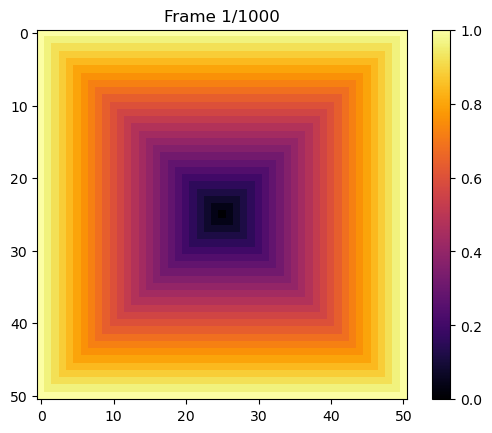

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Initialize figure and heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(u[0], cmap='inferno', interpolation='nearest', animated=True)
fig.colorbar(heatmap)

# Update function for animation
def update(frame):
    heatmap.set_array(u[frame])
    ax.set_title(f"Frame {frame+1}/{u.shape[0]}")
    return [heatmap]

# Create the animation
ani = FuncAnimation(
    fig, update, frames=u.shape[0], interval=100, blit=True
)

plt.show()
ani.save('animation.gif', writer='pillow')